In [53]:
import jsonlines
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark import SparkContext
import numpy as np
import json

# Filtering the videos according to keywords

We want to study youtube videos related to climate change : the first step is to filter our broad dataset of all videos.
For this, we generated a list of keywords related to climate change :

In [2]:
keywords = [
    'climate change', 'global warming', 'greenhouse gases', 'rising sea levels',
    'extreme weather', 'temperature increase', 'climate action', 
    'carbon emissions', 'renewable energy', 'sustainable living',
    'climate science', 'climate crisis', 'climate adaptation',
    'natural disaster', 'extreme heat', 'melting ice cap', 'sea level rise',
    'biodiversity loss', 'deforestation', 'ocean acidification', 'climate policy', 
    'environmental policy',
    'disaster recovery', 'climate refugees',
    'carbon footprint', 'sustainable development', 'green technology',
    'renewable resource', 'eco-friendly',
    'ecosystem disruption', 'impact on climate',
    'paris agreement', 'climate awareness',
    'environmental justice', 'clean energy', 'zero carbon',
    'green infrastructure', 'ozone layer',
    'pollution', 'water scarcity', 'climate education'
]

We create functions to check if a video contains climate change related keywords in its title, description or tags

In [3]:
def about_climate(tags):
    tags_set = set(tags)
    return any(tag.strip().lower() in keywords for tag in tags_set)

def climate_text(text):
    lowercase_text = text.lower()
    return any(keyword in lowercase_text for keyword in keywords)

def climate_related(video):
    return (climate_text(video['title']) or about_climate(video['tags']) or climate_text(video['description']))

Since the original dataset is huge (97 GB), we read and filter the dataset using pyskark in order to get a reduced dataset with only the relevant videos.

In [ ]:
sc = SparkContext()

Load the dataset

In [5]:
path_to_disk = '/Volumes/Maxtor'
path_to_disk_ubuntu = '/media/sebastien/Maxtor'
file_path = '/yt_metadata_en.jsonl'

raw_data = sc.textFile(path_to_disk_ubuntu + file_path)
video_dataset = raw_data.map(lambda x: json.loads(x))

Filter the dataset

In [6]:
climate_videos = video_dataset.filter(climate_related)
climate_videos_collected = climate_videos.collect()

We save the result in a jsonlines file

In [7]:
climate_videos_path = "data/climate_videos_new.jsonl"
with jsonlines.open(climate_videos_path, "w") as jsonl_file:
   jsonl_file.write_all(climate_videos_collected)

## Creating new useful features

We count the number of video uploaded each day.
This will be useful for our future analysis

In [8]:
video_dataset = video_dataset.filter(lambda x: x['upload_date'] is not None)
video_per_date = video_dataset.map(lambda x: (x['upload_date']))
video_per_date = video_per_date.groupBy(lambda x: x[0]).map(lambda x: (x[0], len(x[1]))).collect()

ERROR:root:KeyboardInterrupt while sending command.            (710 + 8) / 2911]
Traceback (most recent call last):
  File "/home/sebastien/miniconda3/envs/2023/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/sebastien/miniconda3/envs/2023/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/home/sebastien/miniconda3/envs/2023/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt
[Stage 0:=============>                                        (711 + 8) / 2911]
KeyboardInterrupt



We save those counts in a json file for later analysis.

In [ ]:
videos_by_date_path = "data/nb_videos_by_date.jsonl"
with jsonlines.open(videos_by_date_path, "w") as jsonl_file:
    jsonl_file.write_all(video_per_date)
sc.stop()

## First look at our preprocessed dataset :

In [98]:
file_path = "data/climate_videos_new.jsonl"
climate_videos_df = pd.read_json(file_path, lines=True)

<Axes: xlabel='categories'>

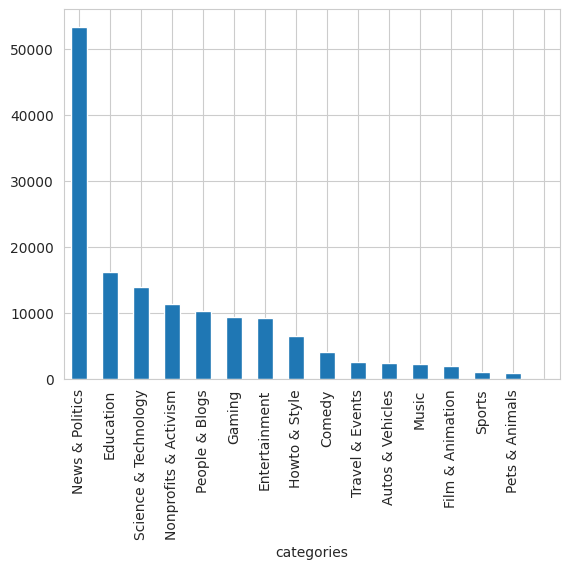

In [99]:
category_counts = climate_videos_df['categories'].value_counts()
category_counts.plot(kind='bar')
plt.title('Number of videos per category')
plt.ylabel('Number of videos')
plt.show()

We see some suspicious categories : gaming ?

When we look at samples, some titles and descriptions do not seem to correspond to climate change related topics...

Let's go further in the filtering process :

# Filtering refinement

Now that we are working on a more reasonable sized dataset, we can use more complex filtering functions to refine it.

In [100]:
categories = category_counts.reset_index()['categories']

for category in categories:
    print(category)
    print(climate_videos_df[
            climate_videos_df['categories'] == category][
                ['title','description','tags']].head(3))

News & Politics
                                      title  \
204                          GLOBAL WARMING   
205   Al Gore's Paranoia is Getting Worse 😂   
206  Bill Nye: Jail Global Warming Skeptics   

                                           description  \
204  Order your “Liberalism: Find a Cure” or shirts...   
205  CNN had a Town Hall meeting with Al Gore calle...   
206  (((Subscribe))) now for more! http://bit.ly/1Q...   

                                                  tags  
204  2018,Global Warming,Climate Change,Painting St...  
205  Al Gore,Climate Crisis,CNN Town Hall,Al Gore T...  
206  Mark Dice (Person),Bill Nye,Global Warming,Jai...  
Education
                                                 title  \
200  Global warming/ climate change -save planet earth   
342                          Introduction to Economics   
343                       Cap and Trade vs. Carbon Tax   

                                           description  \
200  More than providing entertai

For each channel we count the number of videos related to climate change

In [101]:
channels_path = 'data/df_channels_en.tsv'

ratios = climate_videos_df['channel_id'].value_counts().reset_index()
ratios.columns = ['channel', 'count_climate_videos']

channels_df = pd.read_csv(channels_path, delimiter='\t')

channels_df = channels_df.merge(ratios, on ='channel', how ='left').fillna(0)
channels_df['proportion_climate_videos'] = channels_df['count_climate_videos']/channels_df['videos_cc']

We look at  ''''' INSERT HIST TITLE '''''

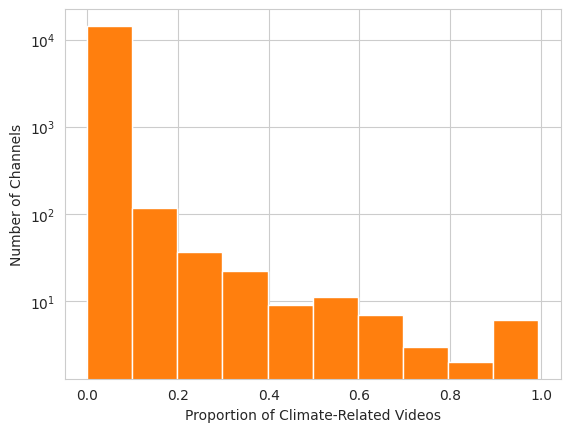

In [102]:
plt.hist(channels_df['proportion_climate_videos'][channels_df['count_climate_videos'] > 0], log = True)
plt.hist(channels_df['proportion_climate_videos'][channels_df['count_climate_videos'] > 0], log = True)
plt.xlabel('Proportion of Climate-Related Videos')
plt.ylabel('Number of Channels')
plt.show()

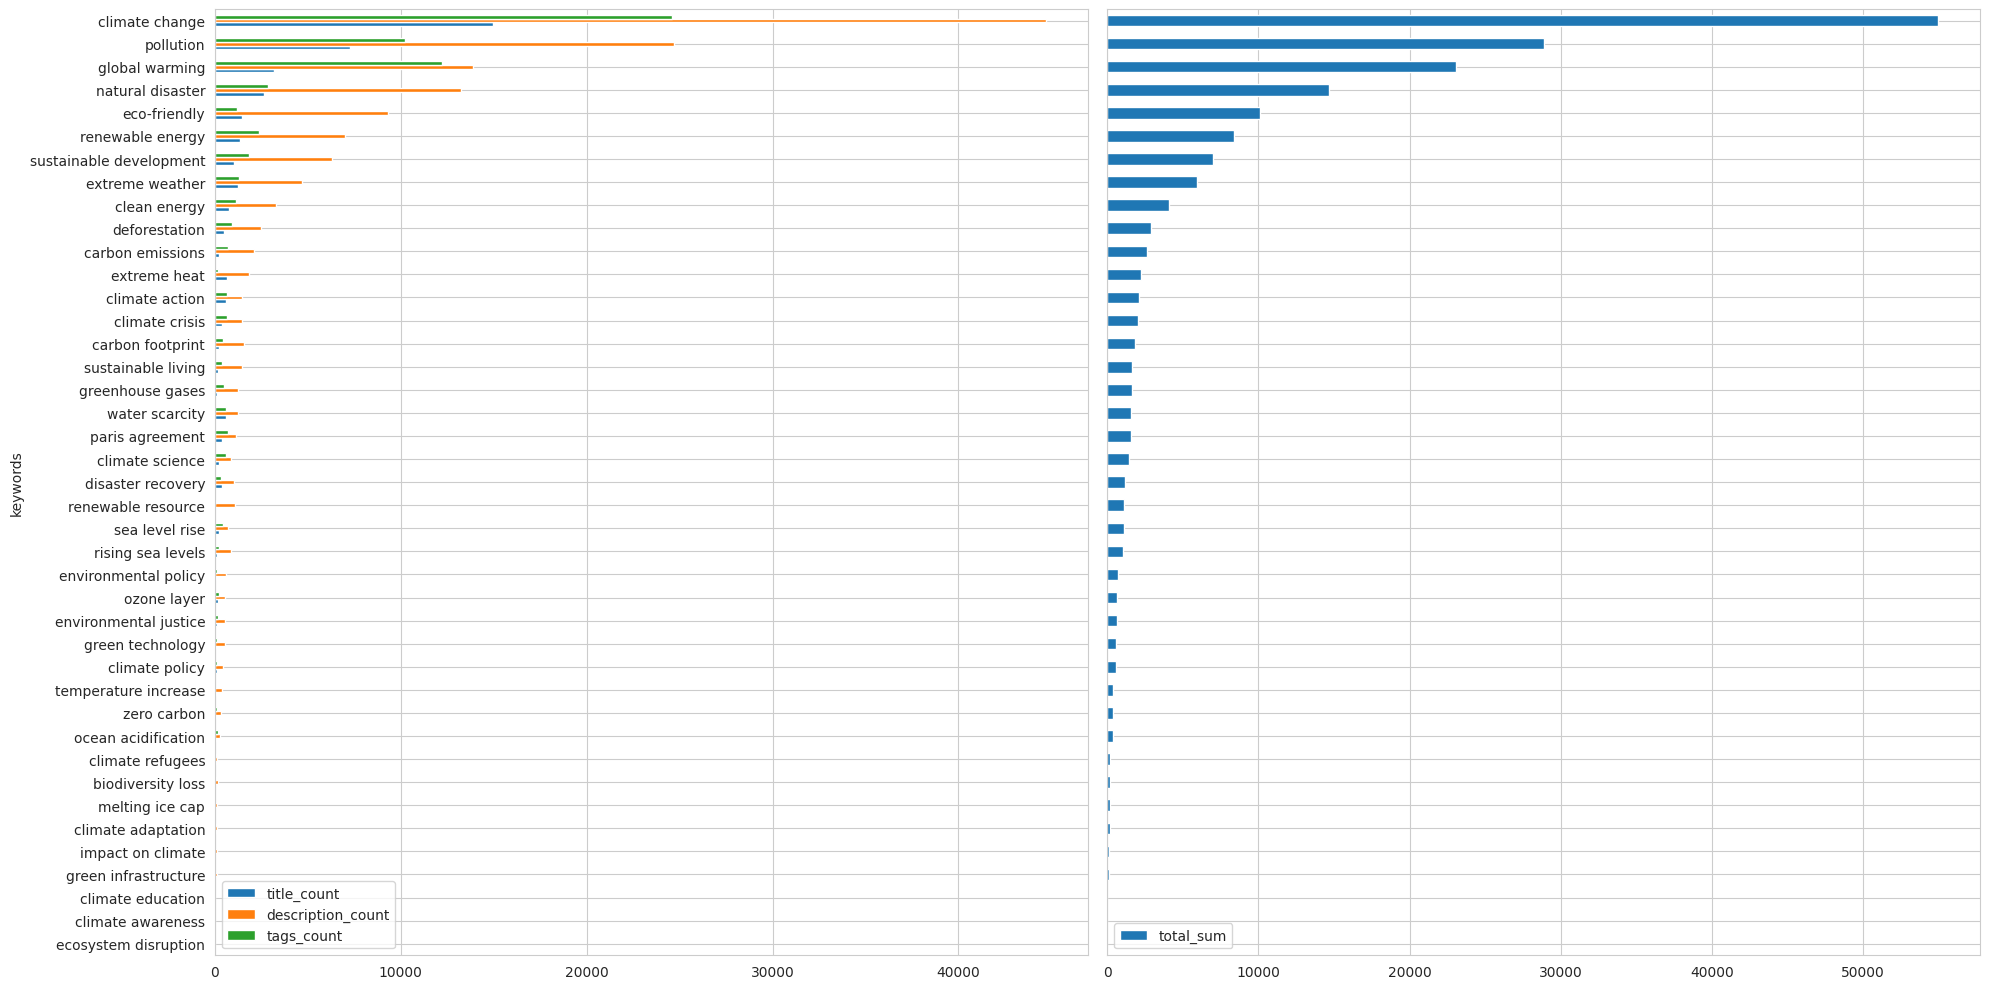

In [103]:
keywords_count = pd.DataFrame(columns=['keywords', 'title_count', 'description_count', 'tags_count', 'total_count'])
keywords_count['keywords'] = keywords
keywords_count.set_index('keywords', inplace=True)

kw_for_column = ['title', 'description', 'tags', 'all_kw']

climate_videos_df_kw = climate_videos_df.copy()
climate_videos_df_kw['all_kw'] = ''

for w in keywords:

    #add a column that concatenates all the keywords contained in the title, description and tag
    climate_videos_df_kw['all_kw'] += [w if w in ' '.join(climate_videos_df.loc[v, c] for c in kw_for_column[:-1]).lower() 
                                       else '' for v in climate_videos_df_kw.index]

    #counts the number of videos that contain the keyword in their title, description, tag and metadata
    keywords_count.loc[w] = [climate_videos_df_kw[c].str.contains(w, case=False).sum() for c in kw_for_column]

keywords_count.sort_values(by=['total_count'], ascending=True, inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

keywords_count[['title_count', 'description_count', 'tags_count']].plot(kind='barh', ax=ax1)
keywords_count[['total_count']].plot(kind='barh', ax=ax2)

fig.tight_layout()
plt.show()


# Load the data

In [104]:
count_file_path = "data/nb_videos_by_date.jsonl"
climate_videos_count_df = pd.read_json(count_file_path, lines=True)

# Convert the upload_date column to datetime and set as index

In [123]:
videos = climate_videos_df.copy()
videos['upload_date'] = pd.to_datetime(climate_videos_df['upload_date'])
videos = videos.set_index('upload_date')
videos.sort_index(inplace=True)
videos.dropna(inplace=True, subset='view_count') # Drop missing values
videos.head()

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,view_count
upload_date,,,,,,,,,,,
2005-07-15,Science & Technology,UCRuvrextOPCX1MP68hJZTCA,2019-11-03 14:45:05.046102,The Wouda Steam Pumping Station near Lemmer in...,2.0,Cl-zL3ebFuI,30,6.0,"stockshot,culture,world,heritage,unesco,wereld...",Wouda Steam Pumping Station - Wouda Stoomgemaal,8137.0
2005-07-17,Travel & Events,UCRuvrextOPCX1MP68hJZTCA,2019-11-03 14:45:05.959805,Venice is unique in the world: an architectura...,2.0,pB7hdto9Svs,30,3.0,"stockshot,culture,world,heritage,unesco,wereld...","City of Venice, Unesco World Heritage",5671.0
2005-07-17,Travel & Events,UCRuvrextOPCX1MP68hJZTCA,2019-11-03 14:45:05.971828,The Grand Canyon is an immense gorge carved by...,2.0,a_se_nXRZaI,30,0.0,"stockshot,culture,world,heritage,unesco,wereld...",Grand Canyon National Park - sunrise,1614.0
2005-07-17,Travel & Events,UCRuvrextOPCX1MP68hJZTCA,2019-11-03 14:45:08.134007,"The name ""Hohe Tauern"" originally meant ""high ...",0.0,RhB6XeV7pV8,33,4.0,"stockshot,austria,alps,mountians,oostenrijk,na...","Hohe Tauern, Austrian Alps",4527.0
2005-07-18,Travel & Events,UCRuvrextOPCX1MP68hJZTCA,2019-11-03 14:45:05.674465,Wadden Sea National Park is an excellent examp...,4.0,tGTt0Zg8kOY,10,2.0,"stockshot,world,heritage,unesco,werelderfgoed,...",Aerial shots Wadden Sea,2549.0


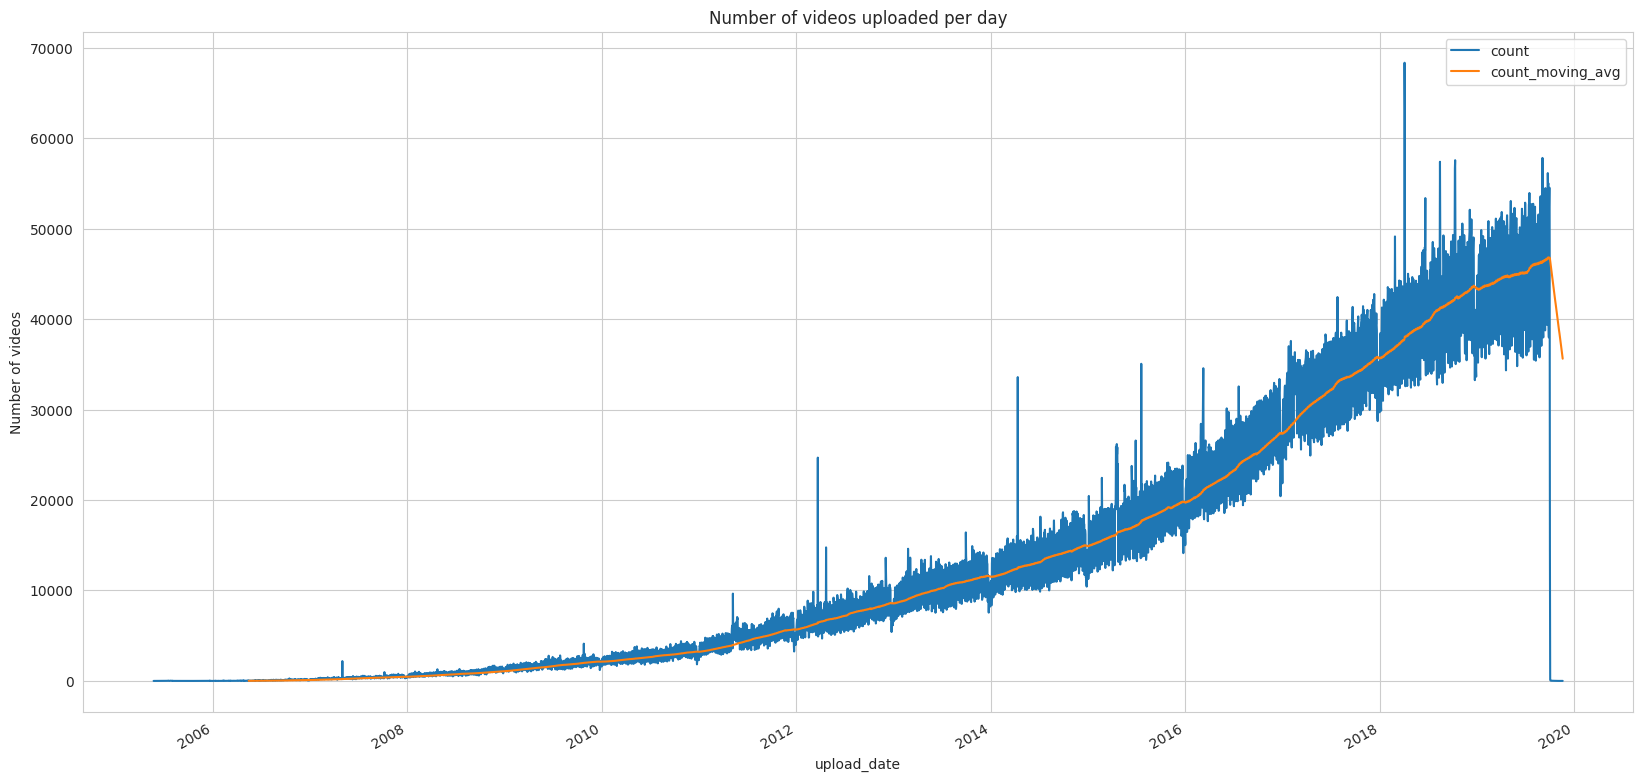

In [124]:
video_count = climate_videos_count_df.copy()
video_count.columns = ['upload_date', 'count']
video_count.set_index('upload_date', inplace=True)
video_count.index = pd.to_datetime(video_count.index)
video_count.sort_index(inplace=True)
video_count['count_moving_avg'] = video_count['count'].rolling(window=200).mean()
video_count[['count', 'count_moving_avg']].plot(figsize=(20, 10))
plt.title('Number of videos uploaded per day')
plt.ylabel('Number of videos')
plt.show()

Keep the data 1 month before the crawl date 2019-09-29 because the data is less relevant and incomplete after this date.
We start from 2010 because the number of videos is very low before this date and would not be representative.

In [125]:
start_date = '2010'
crawl_date = pd.to_datetime(videos['crawl_date'].min()).date() - pd.Timedelta(days=30)
data_count = video_count[start_date:crawl_date]
videos = videos[start_date:crawl_date]

Compute the ratio of climate change related videos over time 

In [126]:
count_per_day = videos.groupby(videos.index)['view_count'].count()

ratio_per_day = count_per_day / data_count['count']
ratio_per_week = count_per_day.resample('W').sum() / data_count['count'].resample('W').sum()
ratio_per_month = count_per_day.resample('M').sum() / data_count['count'].resample('M').sum()

ratio_per_day.dropna(inplace=True)
ratio_per_week.dropna(inplace=True)
ratio_per_month.dropna(inplace=True)
ratios = [ratio_per_day, ratio_per_week, ratio_per_month]

# Plot the number of uploaded videos for each sample rate

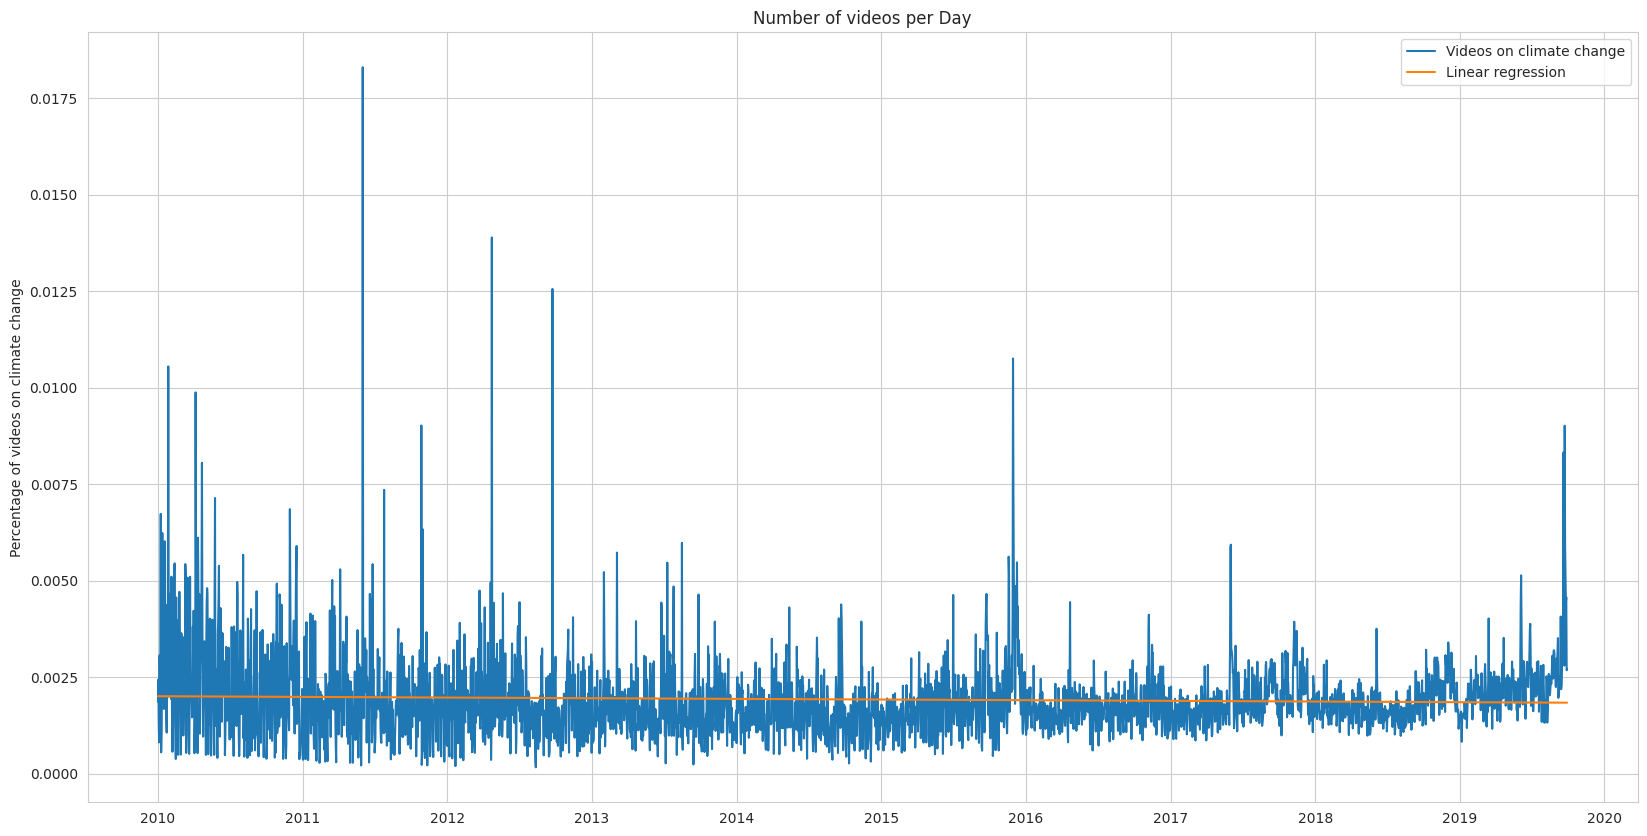

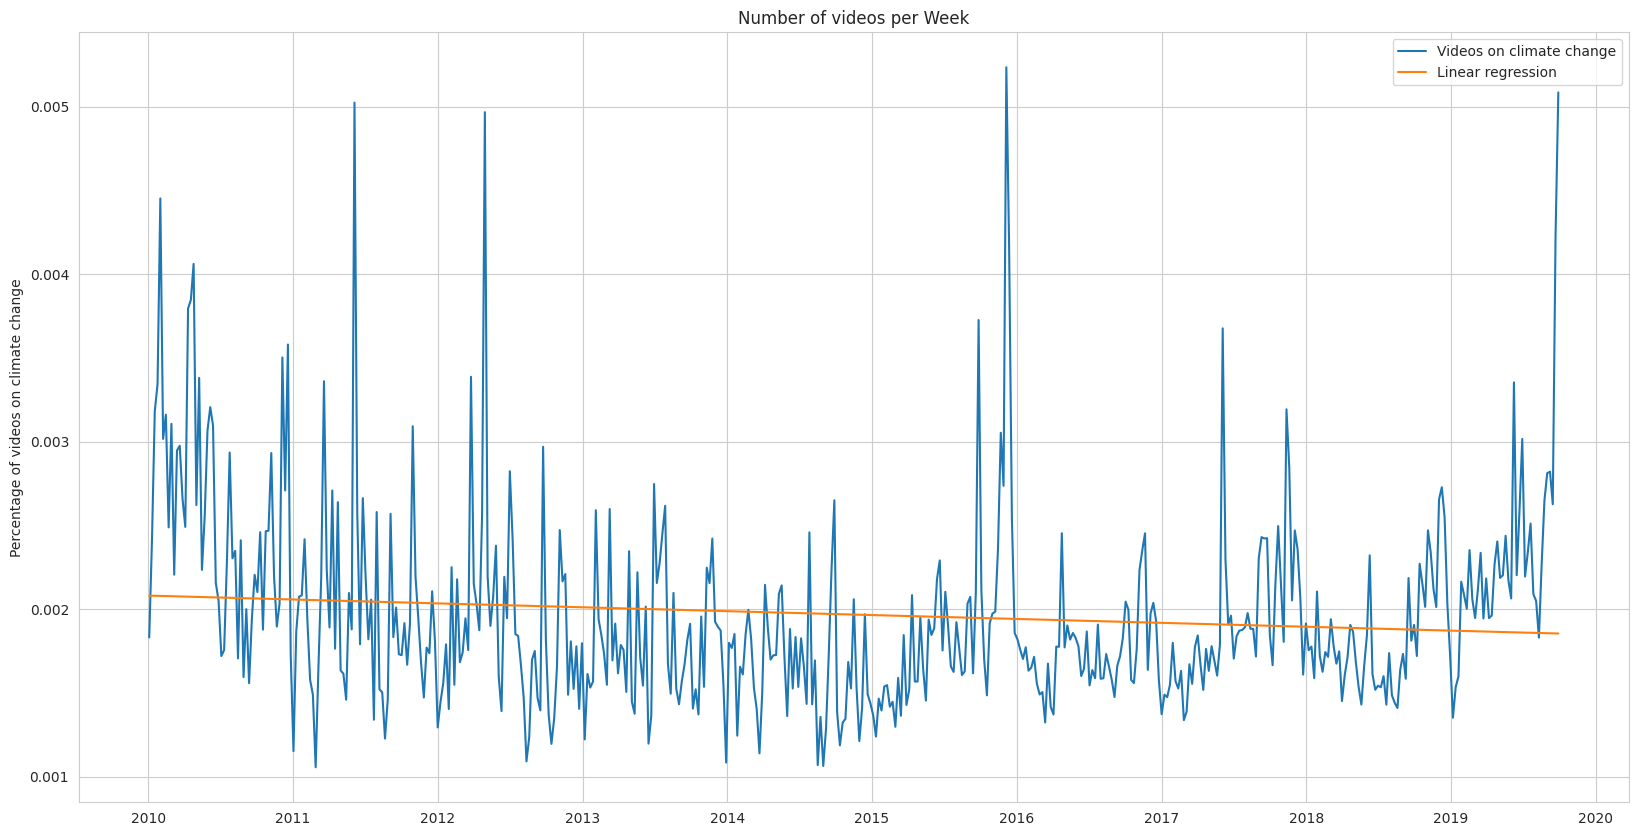

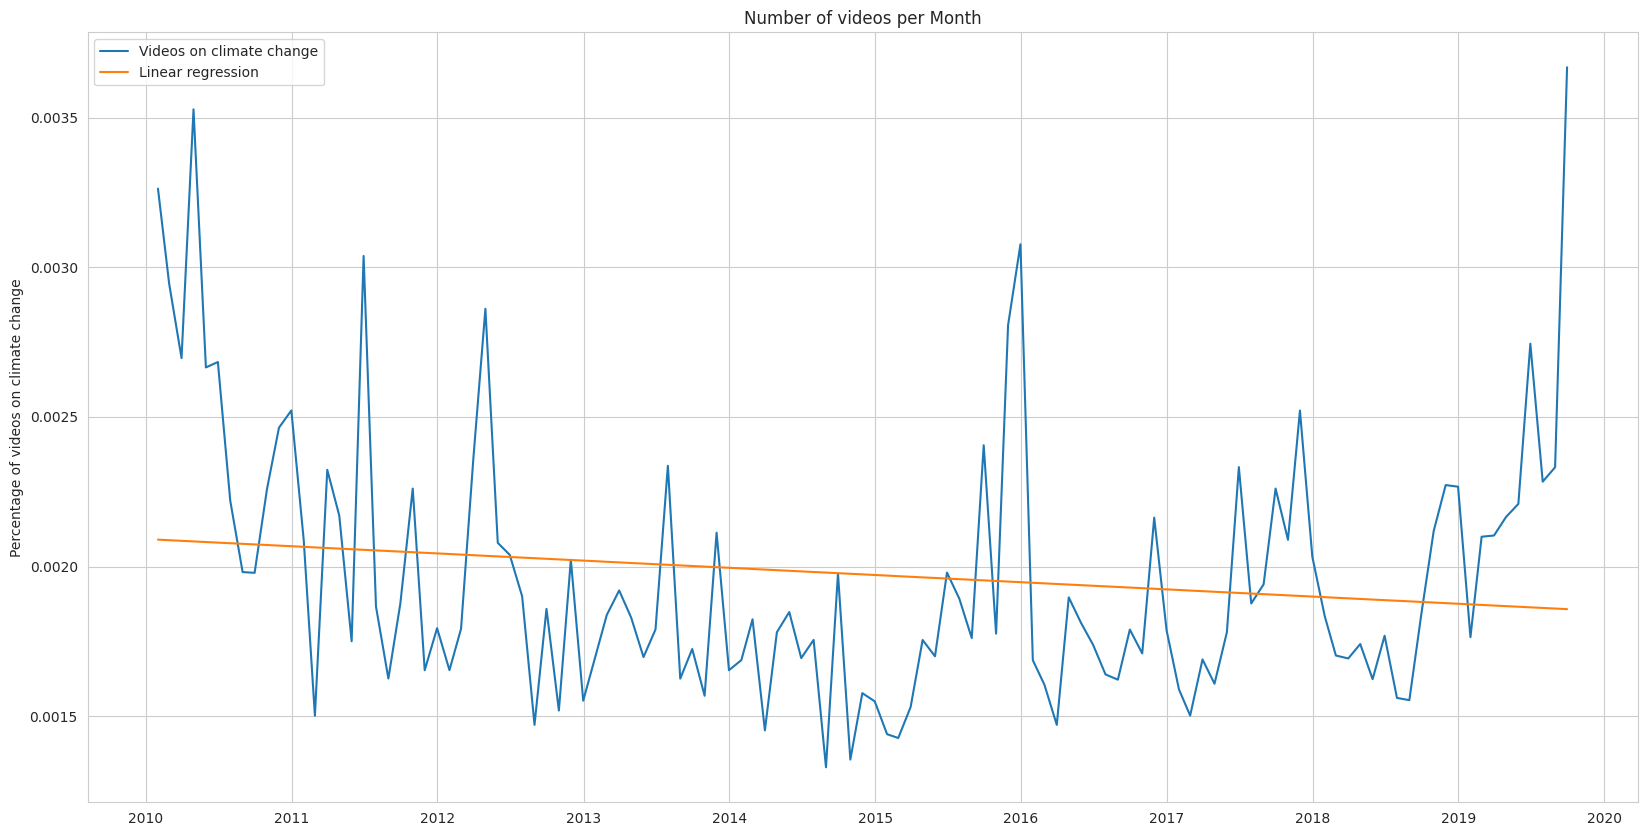

In [127]:
def get_linear_fit(series: pd.Series) -> np.ndarray:
    x = np.arange(len(series))
    y = series.values.tolist()
    coefficients = np.polyfit(x, y, 1)
    linear_fit = np.poly1d(coefficients)
    x_fit = np.linspace(x.min(), x.max(), len(series))
    y_fit = linear_fit(x_fit)
    return y_fit

sample_rate = ['Day', 'Week', 'Month']
for i in range(3):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.plot(ratios[i].index, ratios[i].values, label='Videos on climate change')
    ax.plot(ratios[i].index, get_linear_fit(ratios[i]), label='Linear regression')
    ax.set_title(f'Number of videos per {sample_rate[i]}')
    ax.set_ylabel('Percentage of videos on climate change')
    plt.legend()
    plt.show()

We observe multiple spikes across the years. We will try to find the reason of those spikes.
With the orange line we can see the linear regression of the data. We can see that the number of videos on climate change is decreasing over time.

We think this is due of the fact that the number of videos uploaded on youtube is increasing over time, especially in categories suche as "Gaming" or "Music" which are not related to climate change.

This will have to be investigated and mitigated in the future.

# We will relate the spikes to important climate related events
Load the climate event dataset generated with ChatGPT

In [128]:
climate_events = pd.read_csv('data/climate_events.csv')
climate_events['date'] = pd.to_datetime(climate_events['date'])
climate_events.set_index('date', inplace=True)
climate_events.sort_index(inplace=True)
climate_events = climate_events.loc['2010': '2019-09-28']
climate_events.head()

,name_of_event
date,
2010-01-12,Haiti Earthquake and Its Impact on Vulnerable ...
2010-02-27,Madeira Floods: Flash Flooding and Urban Vulne...
2010-04-20,Deepwater Horizon Oil Spill
2010-07-06,Russia Wildfires and the Role of Forest Manage...
2010-07-07,Mumbai Floods: Urban Flooding and Climate Adap...


Find the 10 most important events according to the number of weekly uploaded videos 

In [129]:
ratio_per_week = ratio_per_week.resample('D').mean().ffill()  # Ups-ample to daily frequency
important_dates = list(climate_events.index)
important_dates = sorted(important_dates, key=lambda x: ratio_per_week.loc[x], reverse=True)
important_dates = important_dates[:10]

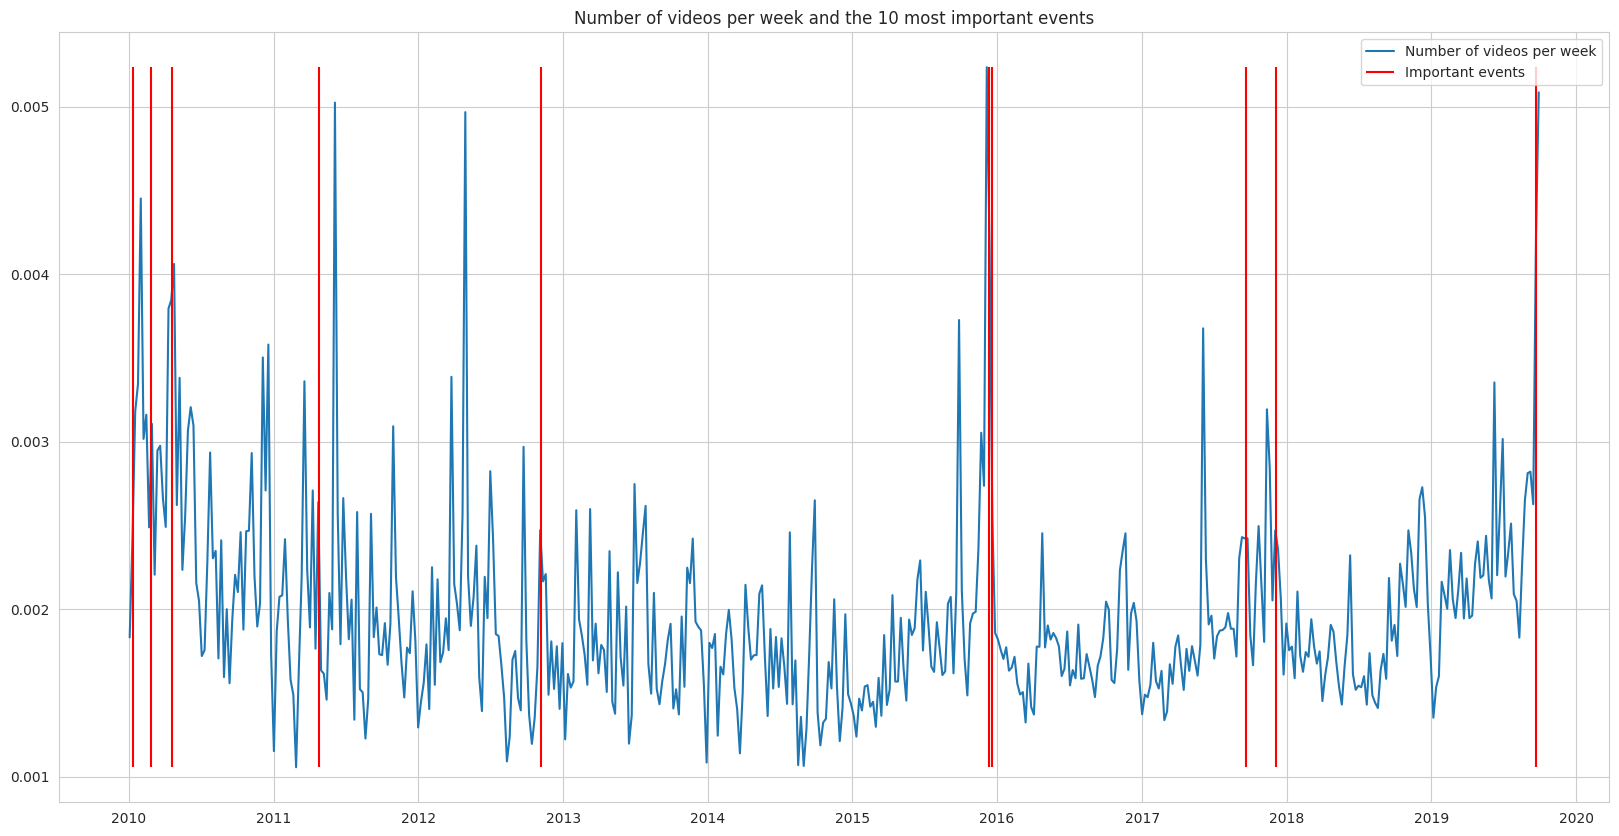

In [130]:
fig = plt.figure(figsize=(20, 10))
plt.plot(ratios[1], label="Number of videos per week")
plt.vlines(important_dates, ymin=ratios[1].min(), ymax=ratios[1].max(), colors='r', label="Important events")
plt.title('Number of videos per week and the 10 most important events')
plt.legend()
plt.show()

# Show the most important event according to the number of uploaded videos

In [131]:
print("The event with the highest spike corresponds to:")
print(f"{climate_events.loc[important_dates[0]].values[0]} on the {important_dates[0]}")

The event with the highest spike corresponds to:
Paris Agreement Adopted at COP21 on the 2015-12-12 00:00:00
